Instalamos algunas librerias

In [1]:
!pip install nltk
!pip install langdetect

                                              0.0/981.5 kB ? eta -:--:--
     --                                      71.7/981.5 kB 2.0 MB/s eta 0:00:01
     -------                                204.8/981.5 kB 3.1 MB/s eta 0:00:01
     -----------                            286.7/981.5 kB 2.5 MB/s eta 0:00:01
     -----------------                      450.6/981.5 kB 2.6 MB/s eta 0:00:01
     --------------------                   532.5/981.5 kB 2.6 MB/s eta 0:00:01
     ------------------------               645.1/981.5 kB 2.4 MB/s eta 0:00:01
     --------------------------             696.3/981.5 kB 2.4 MB/s eta 0:00:01
     -----------------------------          757.8/981.5 kB 2.3 MB/s eta 0:00:01
     ------------------------------         778.2/981.5 kB 2.0 MB/s eta 0:00:01
     ---------------------------------      860.2/981.5 kB 1.9 MB/s eta 0:00:01
     -------------------------------------  972.8/981.5 kB 2.0 MB/s eta 0:00:01
     -------------------------------------- 981

Cargamos el dataset

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

df_criticas = pd.read_csv("./train.csv",encoding='utf-8')
df = df_criticas.copy()
df.head(10)

,ID,review_es,sentimiento
0,0,Uno de los otros críticos ha mencionado que de...,positivo
1,1,Una pequeña pequeña producción.La técnica de f...,positivo
2,2,Pensé que esta era una manera maravillosa de p...,positivo
3,3,"Básicamente, hay una familia donde un niño peq...",negativo
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo
5,5,Probablemente mi película favorita de todos lo...,positivo
6,6,Seguro que me gustaría ver una resurrección de...,positivo
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo
8,8,Alentados por los comentarios positivos sobre ...,negativo
9,9,"Si te gusta la risa original desgarradora, te ...",positivo


Vemos que las reviews estan balanceadas 50/50 en negativas o positivas

Text(0.5, 1.0, 'Porcentaje en sentimiento')

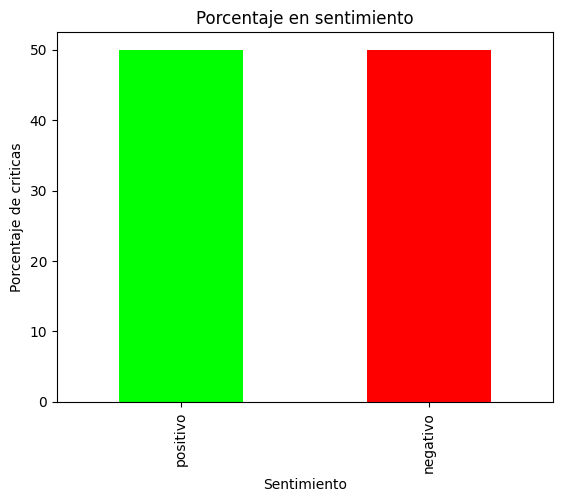

In [26]:
df_porcentaje = df['sentimiento'].value_counts(normalize=True)*100

df_porcentaje.plot(kind='bar',color=[(0,1,0),(1,0,0)])
plt.ylabel("Porcentaje de criticas")
plt.xlabel("Sentimiento")
plt.title("Porcentaje en sentimiento")

Vemos cuantas palabras tienen las reviews

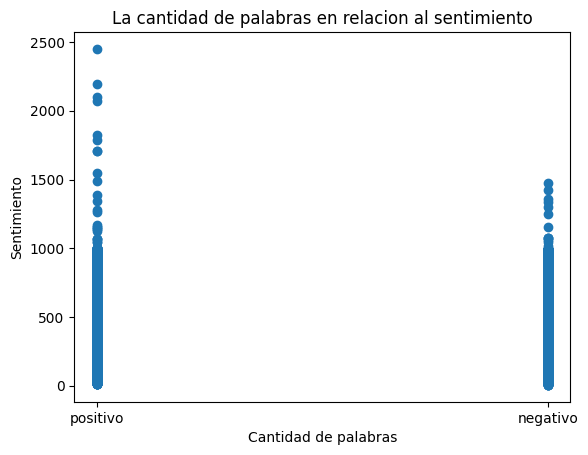

In [27]:
df['num_palabras'] = df['review_es'].str.split().apply(len)
plt.scatter(df['sentimiento'], df['num_palabras'])
plt.xlabel('Cantidad de palabras')
plt.ylabel('Sentimiento')
plt.title('La cantidad de palabras en relacion al sentimiento')
plt.show()

Ahora vamos a realizar un stemming para reducir las palabras a su raiz. Y con CountVectorizer vamos a convertir los textos stemmeados en una representación vectorial.

In [28]:
import nltk
nltk.download('stopwords')

from nltk.stem import SnowballStemmer

# Inicializar stemmer en español
stemmer = SnowballStemmer('spanish')
# Función para aplicar el stemming a una oración
def stem_sentence(sentence):
    words = nltk.word_tokenize(sentence)
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)
# Aplicar el stemming a la columna df.review_es y guardar en una nueva columna
df['stemmed_review'] = df['review_es'].apply(stem_sentence)

df_tfid = df.copy()

vectorizer = CountVectorizer(min_df=0.1, max_df=0.7,token_pattern=r'\b(?:[^\d\W_])+\b')
X = vectorizer.fit_transform(df['stemmed_review'])
palabras = vectorizer.get_feature_names_out()

print(palabras)
print(len(palabras))
print(X.toarray())

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\LUCAS\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['absolut' 'actor' 'actuacion' 'ahor' 'al' 'algo' 'algui' 'algun' 'amig'
 'antes' 'aqu' 'asi' 'aun' 'aunqu' 'años' 'baj' 'bastant' 'bien' 'buen'
 'cad' 'cas' 'casi' 'chic' 'ciert' 'cin' 'com' 'comedi' 'complet' 'con'
 'cos' 'cre' 'cualqui' 'cuand' 'cuent' 'deb' 'dec' 'dej' 'del' 'demasi'
 'desd' 'despues' 'dic' 'diferent' 'director' 'disfrut' 'divert' 'dond'
 'dos' 'durant' 'e' 'efect' 'ella' 'ellos' 'embarg' 'encant' 'encontr'
 'encuentr' 'entonc' 'entre' 'era' 'esa' 'escen' 'ese' 'eso' 'especial'
 'esper' 'est' 'estab' 'estad' 'estan' 'estar' 'estas' 'este' 'esto'
 'estoy' 'excelent' 'final' 'form' 'fue' 'fuer' 'general' 'gran' 'grand'
 'gust' 'ha' 'hab' 'habl' 'hac' 'han' 'hast' 'hay' 'he' 'hech' 'histori'
 'hiz' 'hombr' 'import' 'inclus' 'increibl' 'intent' 'interes' 'jueg'
 'jug' 'l' 'las' 'le' 'llam' 'llev' 'lueg' 'lug' 'mal' 'maner' 'mas'
 'mayor' 'me' 'mejor' 'men' 'mi' 'mientr' 'minut' 'mir' 'mism' 'moment'
 'much' 'muert' 'muy' 'n' 'nad' 'ni' 'ningun' 'niñ' 'nuev' 'nunc' 'o'


Ahora teniendo el vector de para tokenizar cada texto vamos hacerlo agregando cada posición de este como una columna del dataset, de esta forma los modelos que utilicemos en el ensamble lo van a poder entender.

In [29]:
for i, palabra in enumerate(palabras):
    df[palabra] = X.toarray()[:, i]

df.head(10)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\2652835665.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[palabra] = X.toarray()[:, i]
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\2652835665.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[palabra] = X.toarray()[:, i]
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\2652835665.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at o

,ID,review_es,sentimiento,num_palabras,stemmed_review,absolut,actor,actuacion,ahor,al,...,unic,uno,vec,ver,verdader,vez,vi,vid,vist,ya
0,0,Uno de los otros críticos ha mencionado que de...,positivo,345,uno de los otros critic ha mencion que despues...,0,0,0,0,2,...,0,1,0,1,0,0,0,0,1,2
1,1,Una pequeña pequeña producción.La técnica de f...,positivo,161,una pequeñ pequeñ produccion.l tecnic de filma...,0,1,0,0,0,...,0,1,2,1,0,0,0,0,0,0
2,2,Pensé que esta era una manera maravillosa de p...,positivo,173,pens que esta era una maner maravill de pas ti...,0,0,0,0,1,...,0,0,0,1,0,0,0,0,1,0
3,3,"Básicamente, hay una familia donde un niño peq...",negativo,137,"basic , hay una famili dond un niñ pequeñ ( ja...",0,0,0,0,1,...,0,0,0,1,0,0,1,1,0,0
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo,237,el `` amor en el tiemp '' de pett mattei es un...,0,0,1,0,0,...,1,2,0,2,0,0,0,1,0,1
5,5,Probablemente mi película favorita de todos lo...,positivo,123,"probabl mi pelicul favorit de tod los tiemp , ...",0,0,0,0,0,...,0,1,1,1,1,0,0,0,1,0
6,6,Seguro que me gustaría ver una resurrección de...,positivo,157,segur que me gust ver una resurreccion de una ...,0,0,0,0,0,...,0,0,0,2,0,0,0,0,2,0
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo,168,"este espectacul fue una ide increibl , fresc e...",0,0,1,1,0,...,0,0,0,0,1,1,0,0,0,1
8,8,Alentados por los comentarios positivos sobre ...,negativo,120,alent por los comentari posit sobr esta pelicu...,0,0,1,0,1,...,1,1,1,2,1,1,0,0,1,0
9,9,"Si te gusta la risa original desgarradora, te ...",positivo,31,"si te gust la ris original desgarr , te gust e...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Nos quedamos únicamente  con las reviews en español

In [30]:
from langdetect import detect

indices = []

for i, fila in df.iterrows():
    review = fila['stemmed_review']
    if detect(review) != 'es':
        indices.append(i)

df.iloc[indices]

,ID,review_es,sentimiento,num_palabras,stemmed_review,absolut,actor,actuacion,ahor,al,...,unic,uno,vec,ver,verdader,vez,vi,vid,vist,ya
9,9,"Si te gusta la risa original desgarradora, te ...",positivo,31,"si te gust la ris original desgarr , te gust e...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
156,156,From the film's first shot - Keira Knightley a...,negativo,832,from the film 's first shot - keir knightley a...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
160,160,Mystery Men tiene que ser la película más estú...,positivo,44,mystery men tien que ser la pelicul mas estup ...,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
240,240,Esta película fue absolutamente patética.Un ll...,negativo,114,esta pelicul fue absolut patetica.un llam gui ...,1,0,0,0,0,...,1,0,1,1,0,1,0,0,0,0
249,249,'Airport 4' is basically a slopped together me...,negativo,115,'airport 4 ' is basically a slopp togeth mess ...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49833,49833,THE SHOP AROUND THE CORNER is one of the sweet...,positivo,1138,the shop around the corn is one of the sweetes...,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49853,49853,Un músico y compositor europeo se propone capt...,positivo,157,un music y compositor europe se propon captur ...,0,0,0,0,3,...,0,0,0,0,0,0,0,0,0,0
49861,49861,"OK OK, it might be hard to put the entirety of...",negativo,954,"ok ok , it might be hard to put the entirety o...",0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49948,49948,"It is the early morning of our discontent, and...",negativo,972,"it is the early morning of our discontent , an...",0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## Ensamble Hibrido Tipo Voting

Ahora separamos los vectores del resto de columnas que teniamos y dividimos en dataset en train test

In [31]:
df.drop(columns='ID',inplace=True)
df.drop(columns='review_es',inplace=True)
df.drop(columns='stemmed_review',inplace=True)

ds_x=df.drop(['sentimiento'], axis='columns', inplace=False)
ds_y = df['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_x,
                                                    ds_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=4, #semilla
                                                    stratify=df["sentimiento"].values)

In [32]:
import numpy as np
import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
from scipy.stats import uniform, randint

from sklearn.tree import export_graphviz

from sklearn import tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold,RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier  
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier


import xgboost as xgb
import warnings
warnings.filterwarnings('always')

Abrimos el Random Forest y el XGBoost que conseguimos anteriormente con los mejores hiperparametros encontrados de cada uno.

In [33]:
# Cargamos el modelo
import joblib
filename = 'modelos/Random_Forest.sav'
random_forest = joblib.load(filename)

filename_xgb = 'modelos/xgb_model.sav'
xgboost = joblib.load(filename_xgb)

In [34]:
#Creo clasificadores
#KNN
des_tree_clf = DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 15, 
                                         min_samples_leaf=10,
                                         ccp_alpha=0.01)

#Creo ensemble de Votación
vot_clf_count = VotingClassifier(estimators = [('xgb', xgboost), ('rnd', random_forest), ('knn', des_tree_clf)], voting = 'soft', weights=[2,1,1])


#Entreno el ensemble
vot_clf_count.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf_count.predict(x_test)

In [35]:
#Calculo el acuracy del modelo
accuracy=accuracy_score(y_test,pred)
print("Accuracy: "+str(accuracy))

Accuracy: 0.7638


Ahora veremos el resto de metricas

In [43]:
pred

array(['positivo', 'positivo', 'negativo', ..., 'positivo', 'positivo',
       'negativo'], dtype=object)

In [44]:
y_test

12698    positivo
18848    negativo
8372     positivo
5687     positivo
571      positivo
           ...   
46228    positivo
47472    negativo
47488    negativo
14331    positivo
44825    negativo
Name: sentimiento, Length: 15000, dtype: object

AUC: 0.8499238044444445
F1 Score: 0.7743743233776985
Accuracy Score: 0.7638
Recall Score: 0.8106666666666666
Precision Score: 0.741192246738998


c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:219: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


              precision    recall  f1-score   support

    negativo       0.79      0.72      0.75      7500
    positivo       0.74      0.81      0.77      7500

    accuracy                           0.76     15000
   macro avg       0.77      0.76      0.76     15000
weighted avg       0.77      0.76      0.76     15000



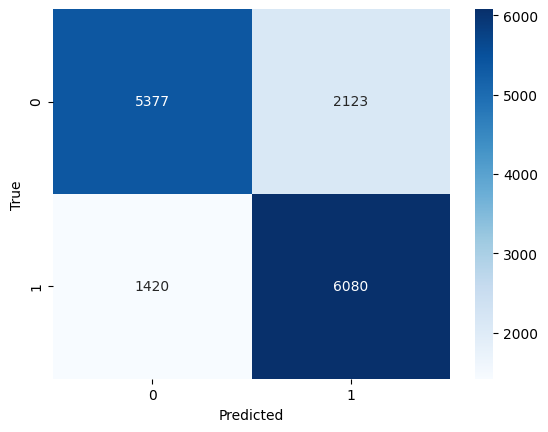

In [46]:
#Evaluo en el set de test
pred_proba= vot_clf_count.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, pred_proba))

#Matriz de Confusion
pred=vot_clf_count.predict(x_test)

print(f"F1 Score: {f1_score(y_test,pred, pos_label= 'positivo')}")
print(f"Accuracy Score: {accuracy_score(y_test,pred)}")
print(f"Recall Score: {recall_score(y_test,pred, pos_label='positivo')}")
print(f"Precision Score: {precision_score(y_test,pred, pos_label='positivo')}")

cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,pred))

## TFID

A continuacion haremos lo mismo pero utilizando otro tipo de tokenizacion. En este caso sera con TfidVectorizer

In [13]:
vectorizer_tfid = TfidfVectorizer(min_df=0.1, max_df=0.7,token_pattern=r'\b(?:[^\d\W_])+\b')
X_tfid = vectorizer_tfid.fit_transform(df_tfid['stemmed_review'])
palabras_tfid = vectorizer_tfid.get_feature_names_out()

print(palabras_tfid)
print(len(palabras_tfid))
print(X_tfid.toarray())

['absolut' 'actor' 'actuacion' 'ahor' 'al' 'algo' 'algui' 'algun' 'amig'
 'antes' 'aqu' 'asi' 'aun' 'aunqu' 'años' 'baj' 'bastant' 'bien' 'buen'
 'cad' 'cas' 'casi' 'chic' 'ciert' 'cin' 'com' 'comedi' 'complet' 'con'
 'cos' 'cre' 'cualqui' 'cuand' 'cuent' 'deb' 'dec' 'dej' 'del' 'demasi'
 'desd' 'despues' 'dic' 'diferent' 'director' 'disfrut' 'divert' 'dond'
 'dos' 'durant' 'e' 'efect' 'ella' 'ellos' 'embarg' 'encant' 'encontr'
 'encuentr' 'entonc' 'entre' 'era' 'esa' 'escen' 'ese' 'eso' 'especial'
 'esper' 'est' 'estab' 'estad' 'estan' 'estar' 'estas' 'este' 'esto'
 'estoy' 'excelent' 'final' 'form' 'fue' 'fuer' 'general' 'gran' 'grand'
 'gust' 'ha' 'hab' 'habl' 'hac' 'han' 'hast' 'hay' 'he' 'hech' 'histori'
 'hiz' 'hombr' 'import' 'inclus' 'increibl' 'intent' 'interes' 'jueg'
 'jug' 'l' 'las' 'le' 'llam' 'llev' 'lueg' 'lug' 'mal' 'maner' 'mas'
 'mayor' 'me' 'mejor' 'men' 'mi' 'mientr' 'minut' 'mir' 'mism' 'moment'
 'much' 'muert' 'muy' 'n' 'nad' 'ni' 'ningun' 'niñ' 'nuev' 'nunc' 'o'


In [14]:
for i, palabra in enumerate(palabras_tfid):
    df_tfid[palabra] = X_tfid.toarray()[:, i]

df_tfid.head(10)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\2812003682.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tfid[palabra] = X_tfid.toarray()[:, i]
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\2812003682.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_tfid[palabra] = X_tfid.toarray()[:, i]
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\2812003682.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider join

,ID,review_es,sentimiento,num_palabras,stemmed_review,absolut,actor,actuacion,ahor,al,...,unic,uno,vec,ver,verdader,vez,vi,vid,vist,ya
0,0,Uno de los otros críticos ha mencionado que de...,positivo,345,uno de los otros critic ha mencion que despues...,0.0,0.000000,0.000000,0.000000,0.130418,...,0.000000,0.094655,0.000000,0.075624,0.000000,0.000000,0.000000,0.000000,0.090949,0.184977
1,1,Una pequeña pequeña producción.La técnica de f...,positivo,161,una pequeñ pequeñ produccion.l tecnic de filma...,0.0,0.115656,0.000000,0.000000,0.000000,...,0.000000,0.111644,0.273764,0.089197,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,2,Pensé que esta era una manera maravillosa de p...,positivo,173,pens que esta era una maner maravill de pas ti...,0.0,0.000000,0.000000,0.000000,0.079070,...,0.000000,0.000000,0.000000,0.091699,0.000000,0.000000,0.000000,0.000000,0.110282,0.000000
3,3,"Básicamente, hay una familia donde un niño peq...",negativo,137,"basic , hay una famili dond un niñ pequeñ ( ja...",0.0,0.000000,0.000000,0.000000,0.110462,...,0.000000,0.000000,0.000000,0.128104,0.000000,0.000000,0.207751,0.165938,0.000000,0.000000
4,4,"El ""amor en el tiempo"" de Petter Mattei es una...",positivo,237,el `` amor en el tiemp '' de pett mattei es un...,0.0,0.000000,0.088716,0.000000,0.000000,...,0.103123,0.182591,0.000000,0.145879,0.000000,0.000000,0.000000,0.094482,0.000000,0.089206
5,5,Probablemente mi película favorita de todos lo...,positivo,123,"probabl mi pelicul favorit de tod los tiemp , ...",0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.159340,0.195360,0.127303,0.199593,0.000000,0.000000,0.000000,0.153101,0.000000
6,6,Seguro que me gustaría ver una resurrección de...,positivo,157,segur que me gust ver una resurreccion de una ...,0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.165861,0.000000,0.000000,0.000000,0.000000,0.199472,0.000000
7,7,"Este espectáculo fue una idea increíble, fresc...",negativo,168,"este espectacul fue una ide increibl , fresc e...",0.0,0.000000,0.100925,0.122729,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.130097,0.092208,0.000000,0.000000,0.000000,0.101482
8,8,Alentados por los comentarios positivos sobre ...,negativo,120,alent por los comentari posit sobr esta pelicu...,0.0,0.000000,0.139123,0.000000,0.098630,...,0.161716,0.143168,0.175532,0.228765,0.179336,0.127108,0.000000,0.000000,0.137562,0.000000
9,9,"Si te gusta la risa original desgarradora, te ...",positivo,31,"si te gust la ris original desgarr , te gust e...",0.0,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Nos quedamos únicamente  con las reviews en español

In [15]:
from langdetect import detect

indices_tfid = []

for i, fila in df_tfid.iterrows():
    review = fila['stemmed_review']
    if detect(review) != 'es':
        indices_tfid.append(i)

df_tfid.iloc[indices_tfid]

,ID,review_es,sentimiento,num_palabras,stemmed_review,absolut,actor,actuacion,ahor,al,...,unic,uno,vec,ver,verdader,vez,vi,vid,vist,ya
9,9,"Si te gusta la risa original desgarradora, te ...",positivo,31,"si te gust la ris original desgarr , te gust e...",0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
33,33,Una de las citas más significativas de toda la...,positivo,692,una de las cit mas signific de tod la pelicul ...,0.0,0.000000,0.0,0.000000,0.128493,...,0.000000,0.046629,0.0,0.000000,0.0,0.000000,0.0,0.241281,0.044803,0.000000
62,62,Así que vamos a empezar!))) La película en sí ...,positivo,79,asi que vam a empez ! ) ) ) la pelicul en si e...,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
66,66,La belleza tetona Stacie Randall interpreta a ...,negativo,392,la bellez teton staci randall interpret a pvc ...,0.0,0.000000,0.0,0.120946,0.070510,...,0.231219,0.000000,0.0,0.000000,0.0,0.090868,0.0,0.000000,0.000000,0.200014
156,156,From the film's first shot - Keira Knightley a...,negativo,832,from the film 's first shot - keir knightley a...,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49833,49833,THE SHOP AROUND THE CORNER is one of the sweet...,positivo,1138,the shop around the corn is one of the sweetes...,0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
49853,49853,Un músico y compositor europeo se propone capt...,positivo,157,un music y compositor europe se propon captur ...,0.0,0.000000,0.0,0.000000,0.610595,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
49861,49861,"OK OK, it might be hard to put the entirety of...",negativo,954,"ok ok , it might be hard to put the entirety o...",0.0,0.000000,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000
49948,49948,"It is the early morning of our discontent, and...",negativo,972,"it is the early morning of our discontent , an...",0.0,0.098077,0.0,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000


In [16]:
df_tfid.drop(columns='ID',inplace=True)
df_tfid.drop(columns='review_es',inplace=True)
df_tfid.drop(columns='stemmed_review',inplace=True)

ds_x=df_tfid.drop(['sentimiento'], axis='columns', inplace=False)
ds_y = df_tfid['sentimiento'].copy()

x_train, x_test, y_train, y_test = train_test_split(ds_x,
                                                    ds_y,
                                                    test_size=0.3,  #proporcion 70/30
                                                    random_state=4, #semilla
                                                    stratify=df["sentimiento"].values)

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score,f1_score, precision_recall_curve, roc_auc_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

import xgboost as xgb
import warnings
warnings.filterwarnings('always')

In [18]:
# Cargamos el modelo
import joblib
filename = 'Random_Forest.sav'
random_forest = joblib.load(filename)

filename_xgb = 'xgb_model.sav'
xgboost = joblib.load(filename_xgb)

In [19]:
#Creo clasificadores
#KNN
des_tree_clf = DecisionTreeClassifier(criterion="entropy",
                                         max_depth = 15, 
                                         min_samples_leaf=10,
                                         ccp_alpha=0.01)

#Creo ensemble de Votación
vot_clf = VotingClassifier(estimators = [('xgb', xgboost), ('rnd', random_forest), ('knn', des_tree_clf)], voting = 'soft', weights=[2,1,1])


#Entreno el ensemble
vot_clf.fit(x_train, y_train)

#Evaluo en conjunto de test
pred = vot_clf.predict(x_test)

In [20]:
#Calculo el accuracy
accuracy=accuracy_score(y_test,pred)

print("Accuracy: "+str(accuracy))

Accuracy: 0.7659333333333334


Vemos el resto de las metricas

AUC: 0.8333770666666667
F1 Score: 0.7499341238471673
Accuracy Score: 0.7469333333333333
Recall Score: 0.7589333333333333
Precision Score: 0.7411458333333333


c:\Users\LUCAS\AppData\Local\Programs\Python\Python310\lib\site-packages\seaborn\matrix.py:219: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  self.cmap = mpl.cm.get_cmap(cmap)


              precision    recall  f1-score   support

    negativo       0.75      0.73      0.74      7500
    positivo       0.74      0.76      0.75      7500

    accuracy                           0.75     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.75      0.75      0.75     15000



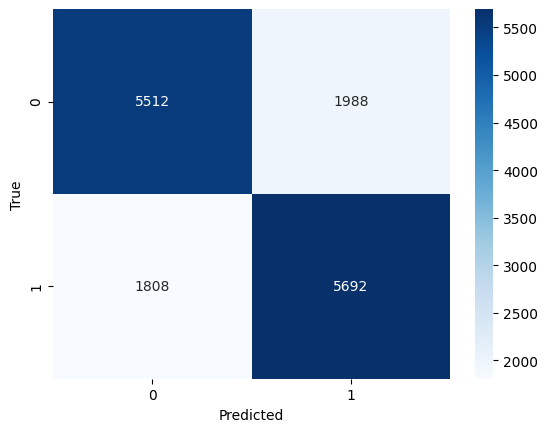

In [47]:
#Evaluo en el set de test
pred_proba= vot_clf.predict_proba(x_test)[:, 1]
print('AUC:',roc_auc_score(y_test, pred_proba))

#Matriz de Confusion
pred=vot_clf.predict(x_test)

print(f"F1 Score: {f1_score(y_test,pred, pos_label= 'positivo')}")
print(f"Accuracy Score: {accuracy_score(y_test,pred)}")
print(f"Recall Score: {recall_score(y_test,pred, pos_label='positivo')}")
print(f"Precision Score: {precision_score(y_test,pred, pos_label='positivo')}")

cm = confusion_matrix(y_test,pred)
sns.heatmap(cm, cmap='Blues',annot=True,fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')

#Reporte
print(classification_report(y_test,pred))

Como podemos ver los resultados del ensamble utilizando CountVectorizer y TfidVectorizer son muy parecidos. Nos quedaremos con CountVectorizer.

## Guardamos el modelo

In [37]:
# Guardar el arbol
import joblib
filename = 'EnsambleVoting.sav'
joblib.dump(vot_clf_count, filename)

['EnsambleVoting.sav']

## Predict de kaggle

Ahora haremos el predict para kaggle

In [38]:
df_criticas_test = pd.read_csv('./test.csv')
df_test = df_criticas_test.copy()
df_test['stemmed_review'] = df_test['review_es'].apply(stem_sentence)
df_test.head(10)

,ID,review_es,stemmed_review
0,60000,La mayor virtud de esta película es su existen...,la mayor virtud de esta pelicul es su existenc...
1,60001,"No soy un experto cinéfilo, pero pocas veces m...","no soy un expert cinefil , per poc vec me hab ..."
2,60002,Si no eres un incondicional del humor estilo T...,si no eres un incondicional del humor estil te...
3,60003,"No sé qué está pasando, si la gente se deja ll...","no se que esta pas , si la gent se dej llev po..."
4,60004,"Pero cuando amanece,y me quedo solo,siento en ...","per cuand amanec , y me qued sol , sient en el..."
5,60005,La llegada de Rafa a Euskadi es como ponerse a...,la lleg de raf a euskadi es com pon a ver 8 ap...
6,60006,El nivel del cine y lo peor la capacidad intel...,el nivel del cin y lo peor la capac intelectua...
7,60007,Es triste ver una película como ésta y escucha...,es trist ver una pelicul com esta y escuch a t...
8,60008,Puedo entender que Torrente I y II y Lo imposi...,pued entend que torrent i y ii y lo impos fuer...
9,60009,"-Ahivalohostia, Txomin, qué montón de gente ri...","-ahivalohosti , txomin , que monton de gent ri..."


In [39]:
df_test['num_palabras'] = df_test['stemmed_review'].str.split().apply(len)

vectorizer = CountVectorizer(vocabulary=palabras)
matriz_caracteristicas_test = vectorizer.fit_transform(df_test['stemmed_review'])

for i, palabra in enumerate(palabras):
    df_test[palabra] = matriz_caracteristicas_test.toarray()[:, i]


_df_test = df_test.drop(columns='ID',inplace=False)
_df_test.drop(columns='review_es',inplace=True)
_df_test.drop(columns='stemmed_review',inplace=True)

_df_test.head(10)

C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\1514846974.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[palabra] = matriz_caracteristicas_test.toarray()[:, i]
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\1514846974.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_test[palabra] = matriz_caracteristicas_test.toarray()[:, i]
C:\Users\LUCAS\AppData\Local\Temp\ipykernel_8076\1514846974.py:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, 

,num_palabras,absolut,actor,actuacion,ahor,al,algo,algui,algun,amig,...,unic,uno,vec,ver,verdader,vez,vi,vid,vist,ya
0,909,1,0,0,0,5,0,0,0,1,...,1,1,0,2,0,0,0,1,1,2
1,236,0,1,0,0,0,1,0,2,0,...,0,0,1,2,0,0,0,1,0,0
2,141,0,0,0,0,1,0,0,2,0,...,0,0,0,0,0,1,0,0,0,0
3,354,0,0,0,1,5,1,0,0,0,...,1,0,1,0,0,0,0,0,0,1
4,346,0,0,0,1,1,0,0,0,0,...,0,0,0,2,0,1,0,0,0,0
5,446,1,0,0,0,1,0,0,1,1,...,1,1,0,1,0,0,0,0,0,0
6,113,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
7,389,0,0,0,0,2,0,0,2,0,...,0,2,0,2,0,0,0,0,0,0
8,188,0,0,0,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
9,722,1,1,0,1,1,0,0,1,1,...,1,1,0,2,0,0,0,0,2,2


In [40]:
pred_kaggle_vot = vot_clf_count.predict(_df_test)
df_kaggle_rf = pd.DataFrame({'ID': df_test['ID'], 'sentimiento': pred_kaggle_vot})
df_kaggle_rf.head(10)

,ID,sentimiento
0,60000,negativo
1,60001,positivo
2,60002,negativo
3,60003,negativo
4,60004,positivo
5,60005,negativo
6,60006,negativo
7,60007,negativo
8,60008,negativo
9,60009,negativo


In [41]:
df_kaggle_rf.shape[0]

8599

In [42]:
df_kaggle_rf.to_csv('pred_kaggle_voting_4.csv', index=False)